In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# import warnings
# warnings.filterwarnings('ignore')
# pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #float show 3 decimal

In [2]:
train = pd.read_csv('train.csv', sep=',', index_col='Id')
test = pd.read_csv('test.csv', sep=',', index_col='Id')

# outliers = [30, 88, 462, 631, 1322]
# train = train.drop(train.index[outliers])

print("Data shape \n    Train : {}\n    Test  : {}".format(train.shape,test.shape))

Data shape 
    Train : (1460, 80)
    Test  : (1459, 79)


In [3]:
# for feat in [col for col in train.columns if train[col].dtypes != 'object']: 
#     var1 = 'SalePrice'
#     var2 = feat
#     train[[var1,var2]].plot.scatter(x=var2, y=var1, ylim=(0,800000));

In [4]:
from scipy import stats
from scipy.stats import norm, skew

## Train - Target

Data shape 
    Train : (1460, 79)
    Test  : (1459, 79)


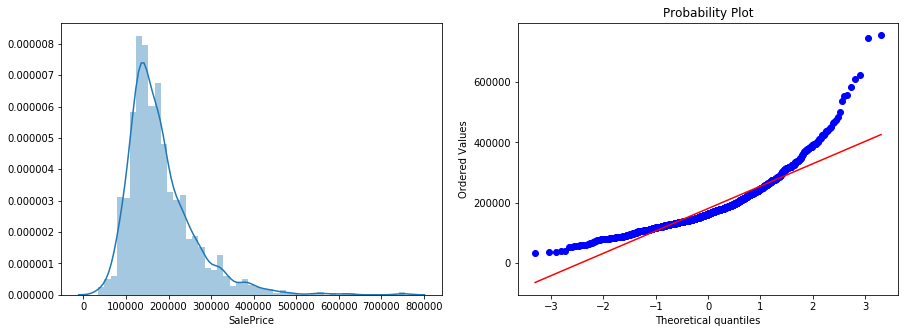

In [5]:
y = train['SalePrice']
train.drop('SalePrice', axis=1, inplace=True)

print("Data shape \n    Train : {}\n    Test  : {}".format(train.shape,test.shape))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1); sns.distplot(y)
plt.subplot(1,2,2); stats.probplot(y, plot=plt);

In [6]:
print(y.name +
      "\n\t\tSkewness  : {:.3f}  | Kurtosis  : {:.3f}".format(y.skew(), y.kurt()))

yt_log1p = np.log1p(y)
yt_log1p_i = np.expm1(yt_log1p)

print("  by log1p " +
      "\n\t\tSkewness  : {:.3f}  | Kurtosis  : {:.3f}".format(yt_log1p.skew(), yt_log1p.kurt()))

def johnsonsu_transform(data):
    gamma, eta, epsilon, lmbda = stats.johnsonsu.fit(y)
    data_trans = gamma + eta*np.arcsinh((y-epsilon)/lmbda)
    return data_trans, gamma, eta, epsilon, lmbda

def johnsonsu_inverse(data, gamma, eta, epsilon, lmbda):
    return lmbda*np.sinh((data-gamma)/eta) + epsilon

yt_johnsonsu, g, et, ep, l = johnsonsu_transform(y)
yt_johnsonsu_i = johnsonsu_inverse(yt_johnsonsu, g, et, ep, l)

print("  by JhonsonSU" +
      "\n\t\tSkewness  : {:.3f} | Kurtosis  : {:.3f}".format(yt_johnsonsu.skew(), yt_johnsonsu.kurt()))

SalePrice
		Skewness  : 1.883  | Kurtosis  : 6.536
  by log1p 
		Skewness  : 0.121  | Kurtosis  : 0.810
  by JhonsonSU
		Skewness  : -0.001 | Kurtosis  : -0.084


alpha		: 0.001
p (before tf)   : 0.00000
p (after tf)	: 0.82183


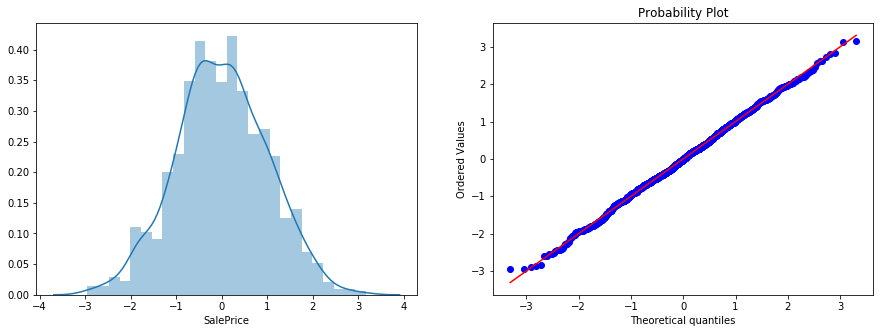

In [7]:
alpha = 1e-3
_, p = stats.normaltest(y)
_, pt = stats.normaltest(yt_johnsonsu)
    
# null hypothesis: data comes from a normal distribution
print("alpha\t\t: {}\np (before tf)   : {:.5f}\np (after tf)\t: {:.5f}".format(alpha,p,pt))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1); sns.distplot(yt_johnsonsu)
plt.subplot(1,2,2); stats.probplot(yt_johnsonsu, plot=plt);

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

# Plot that matters

In [ ]:
# temp = train['YrSold'] - train['YearBuilt']
# sns.pairplot(pd.concat([train[['YrSold', 'MoSold', 'YearBuilt']], y, temp], axis=1));
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1); sns.distplot(train['MoSold'])
# plt.subplot(1,2,2); sns.boxplot(train['MoSold'].astype('object'), y); #plt.hlines(y.mean(), -1,12);

In [ ]:
# plt.figure(figsize=(15,10)); sns.stripplot(train['Utilities'], y, hue=train['MSSubClass'], palette="RdBu",jitter=True);

In [ ]:
# g = sns.FacetGrid(train, col='MSZoning', height=8, aspect=0.3)
# g = g.map(sns.countplot, 'Street')

In [ ]:
# plt.figure(figsize=(15,7))
# ax = sns.stripplot(x=train['MSSubClass'], y=y, hue=train['Exterior1st'],
#                     jitter=True,
#                     palette="Set2", dodge=True)

In [ ]:
# plt.figure(figsize=(15,7))
# ax = sns.stripplot(x=train['MSZoning'], y=y, hue=train['Exterior1st'],
#                     jitter=True,
#                     palette="Set2", dodge=True)

In [ ]:
# groups = ['MSZoning', 'BldgType']
# temp = pd.concat([df[groups], y], axis=1).groupby(groups).count()
# temp

In [ ]:
# sns.scatterplot(x=train[train['PoolArea'] !=0]['PoolArea'], y=y);

## Preprocessing and Arrange Pipeline

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
def preprocess_data(df):
    # 'MSSubClass' int data means class 
    # 'MoSold' turns into object, distplot show most sale in midyear, plot show concave relationship
    # 'YearBuilt' and 'YrSold' turns into 'YrAge', corr value not significantly increase id 'MoSold' added
    
    cat_nan_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType','GarageFinish',
                    'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond',
                    'BsmtQual', 'MasVnrType']
    cat_nan_mode = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual', 'Utilities', 'Functional', 'MSZoning']
    num_nan_zero = ['GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                    'GarageCars', 'GarageArea', 'TotalBsmtSF']  
    num_nan_med = ['LotFrontage', 'MasVnrArea']
    
    nan_transformer = ColumnTransformer(
        transformers=[
            ('cat_nan_fill_None', SimpleImputer(strategy="constant", fill_value='None'), cat_nan_none),
            ('cat_nan_fill_mode', SimpleImputer(strategy="most_frequent"), cat_nan_mode),
            ('num_nan_fill_zero', SimpleImputer(strategy="constant", fill_value=0), num_nan_zero),
            ('num_nan_fill_med', SimpleImputer(strategy="most_frequent"), num_nan_med)
        ])
    
    df[['MSSubClass', 'MoSold']] = df[['MSSubClass', 'MoSold']].astype('object')
    df['YrAge'] = df['YrSold'] - df['YearBuilt']
    df.drop(['YearBuilt', 'YrSold'],axis=1, inplace=True)
    
    
    return df

In [9]:
df = train.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

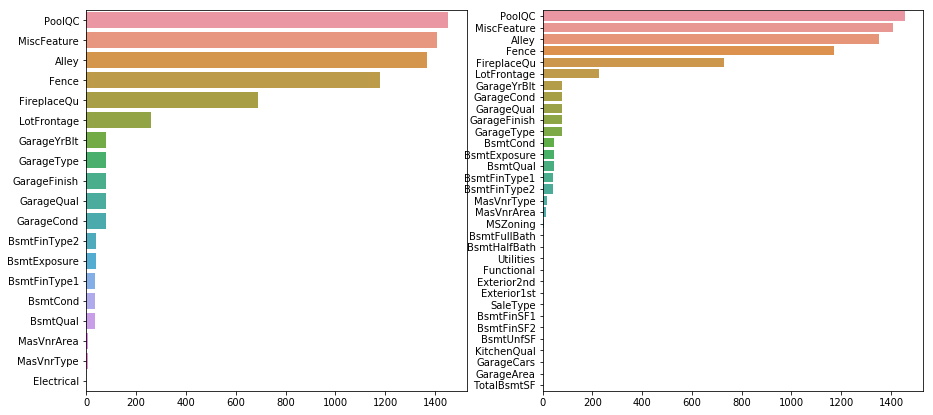

In [10]:
train_na = train.isnull().sum()
train_na = train_na[train_na>0].sort_values(ascending=False)

test_na = test.isnull().sum()
test_na = test_na[test_na>0].sort_values(ascending=False)

plt.figure(figsize=(15,7))
plt.subplot(1,2,1); sns.barplot(train_na, train_na.index)
plt.subplot(1,2,2); sns.barplot(test_na, test_na.index);

.PoolQC          1453 object   Pool quality - NA No pool
.MiscFeature     1406 object   Miscellaneous feature - NA No misc
.Alley           1369 object   Type of alley access to property - NA No alley access
.Fence           1179 object   Fence quality - NA No fence
.FireplaceQu      690 object   Fireplace quality - NA No Fireplace
.GarageType        81 object   Garage location - NA No Garage
.GarageFinish      81 object   Interior finish of the garage - NA No Garage
.GarageQual        81 object   Garage quality - NA No Garage
.GarageCond        81 object   Garage condition - NA No Garage
.BsmtFinType2      38 object   Rating of basement finished area (if multiple types) - NA No basement
.BsmtExposure      38 object   Refers to walkout or garden level walls - NA No basement
.BsmtFinType1      37 object   Rating of basement finished area - NA No basement
.BsmtCond          37 object   General condition of the basement - NA No basement
.BsmtQual          37 object   Height of the basement in range - NA No basement
.MasVnrType         8 object   Masonry veneer type - NA means No masonry veneer
.Electrical         1 object   Electrical system


.GarageCond        78 object
.GarageQual        78 object
.GarageFinish      78 object
.GarageType        76 object
.BsmtCond          45 object
.BsmtExposure      44 object
.BsmtQual          44 object
.BsmtFinType1      42 object
.BsmtFinType2      42 object
.MasVnrType        16 
.MSZoning           4 object
.Utilities          2 object
.Functional         2 object
.Exterior2nd        1 object
.Exterior1st        1 object
.SaleType           1 object
.KitchenQual        1 object

- train data may not contain all categories posible
- imputer by mode too naive, it may related to some categories

LotFrontage      259 float    Linear feet of street connected to property
GarageYrBlt       81 float    Year garage was built - NA No Garage
MasVnrArea         8 float    Masonry veneer area


LotFrontage      227 float
GarageYrBlt       78 float 
MasVnrArea        15 float
BsmtFullBath       2 int
BsmtHalfBath       2 int
BsmtFinSF1         1 int
BsmtFinSF2         1 int
BsmtUnfSF          1 int
GarageCars         1 int
GarageArea         1 int
TotalBsmtSF        1 int

In [32]:
df = train.copy()

In [33]:
    cat_nan_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType','GarageFinish',
                    'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond',
                    'BsmtQual', 'MasVnrType']
    cat_nan_mode = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual', 'Utilities', 'Functional', 'MSZoning']
    num_nan_zero = ['GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                    'GarageCars', 'GarageArea', 'TotalBsmtSF']  
    num_nan_med = ['LotFrontage', 'MasVnrArea']
    
    cat_nan_transformer = ColumnTransformer(
        transformers=[
            ('cat_nan_fill_None', SimpleImputer(strategy="constant", fill_value='None'), cat_nan_none),
            ('cat_nan_fill_mode', SimpleImputer(strategy="most_frequent"), cat_nan_mode)
        ])
    
    num_nan_transformer = ColumnTransformer(
        transformers=[
            ('num_nan_fill_zero', SimpleImputer(strategy="constant", fill_value=0), num_nan_zero),
            ('num_nan_fill_med', SimpleImputer(strategy="median"), num_nan_med)
        ])
    
    cat_nan_transformer.fit(df)
    num_nan_transformer.fit(df)
    
    reduced_df = df.drop(cat_nan_none+cat_nan_mode+num_nan_zero+num_nan_med, axis=1).reset_index(drop=True)
    imputed_df = pd.concat([reduced_df,
                            pd.DataFrame(cat_nan_transformer.transform(df), columns=cat_nan_none+cat_nan_mode),
                            pd.DataFrame(num_nan_transformer.transform(df), columns=num_nan_zero+num_nan_med)
                           ], axis=1)
    imputed_df = imputed_df.astype({index:str(value) for index, value in df.dtypes.items()})
    
    imputed_df['YrAge'] = imputed_df['YrSold'] - imputed_df['YearBuilt']
    imputed_df[['MSSubClass', 'MoSold', 'YrSold']] = imputed_df[['MSSubClass', 'MoSold', 'YrSold']].astype('object')
    imputed_df['HasPool'] = imputed_df['PoolArea'].apply(lambda x: 1 if x>0 else 0)
    imputed_df['HasRemod'] = (imputed_df['YearRemodAdd'] - imputed_df['YearBuilt']).apply(lambda x: 1 if x>0 else 0)
    imputed_df.drop(['PoolArea', 'YrSold', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)
    
   
    

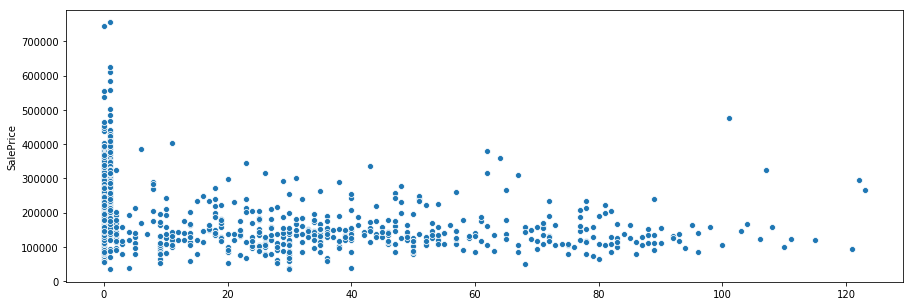

In [16]:
temp = df['YearRemodAdd'] - df['YearBuilt']
plt.figure(figsize=(15,5)); sns.scatterplot(temp, y);

In [17]:
plt.figure(figsize=(15,5)); sns.scatterplot(temp, y, hue=temp2);

NameError: name 'temp2' is not defined

<Figure size 1080x360 with 0 Axes>

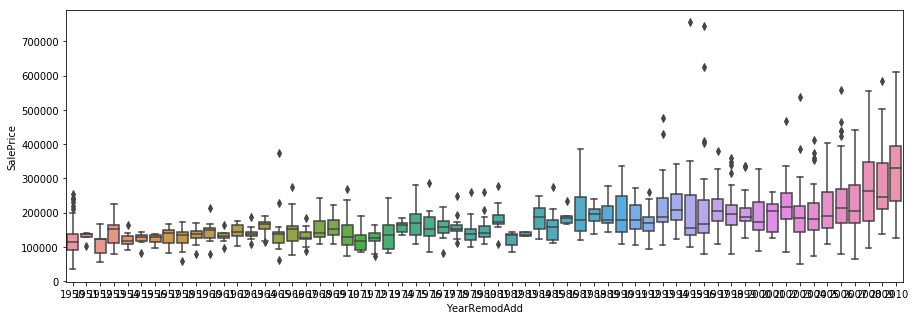

In [18]:
plt.figure(figsize=(15,5)); sns.boxplot(df['YearRemodAdd'], y);

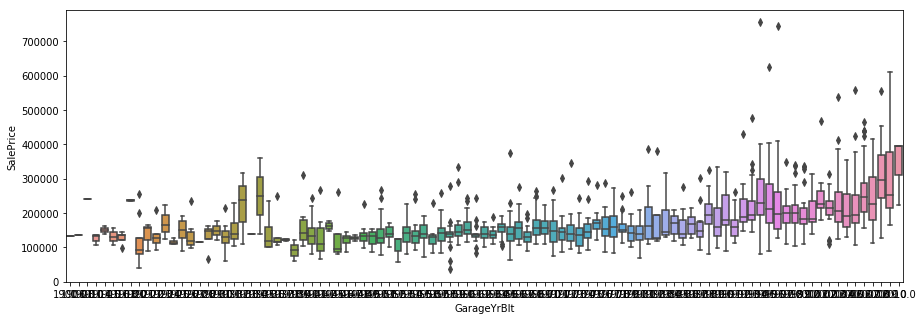

In [19]:
plt.figure(figsize=(15,5)); sns.boxplot(df['GarageYrBlt'], y);

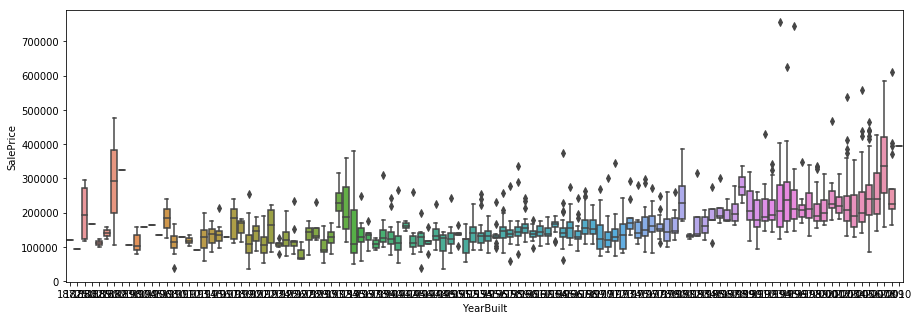

In [20]:
plt.figure(figsize=(15,5)); sns.boxplot(df['YearBuilt'], y);

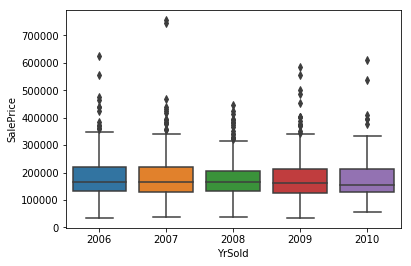

In [21]:
sns.boxplot(df['YrSold'], y)

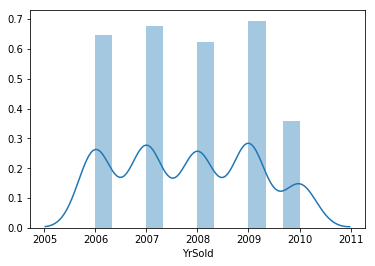

In [22]:
sns.distplot(df['YrSold'])

In [23]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
MSSubClass       1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 non-null object
Heating          1460 non-null object
HeatingQC        1460 non-null object
CentralAir       1460 non-null object
1stFlrSF         1460 n

In [24]:
imputed_df['KitchenAbvGr']

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       2
9       2
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      2
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
1430    1
1431    1
1432    1
1433    1
1434    1
1435    1
1436    1
1437    1
1438    1
1439    1
1440    1
1441    1
1442    1
1443    1
1444    1
1445    1
1446    1
1447    1
1448    1
1449    1
1450    2
1451    1
1452    1
1453    1
1454    1
1455    1
1456    1
1457    1
1458    1
1459    1
Name: KitchenAbvGr, Length: 1460, dtype: int64

In [34]:
num_df = imputed_df.select_dtypes(exclude='object')

C:\Users\FadhelAdlansyah\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


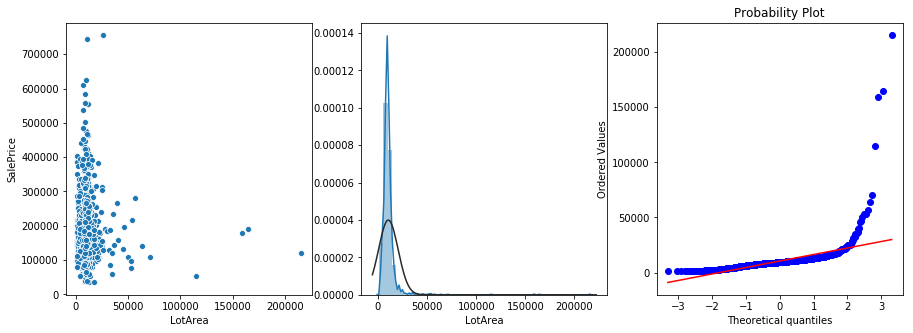

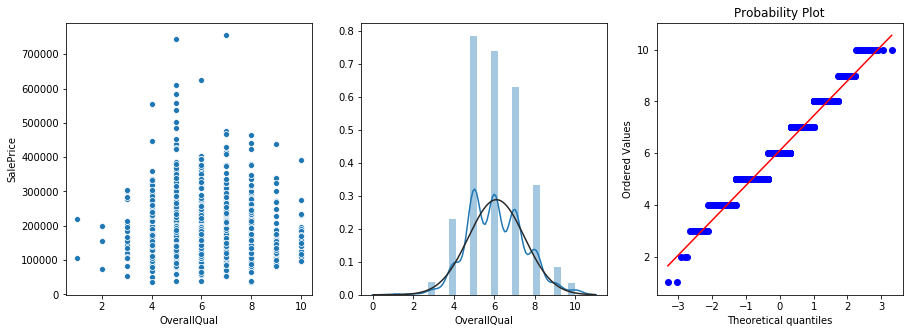

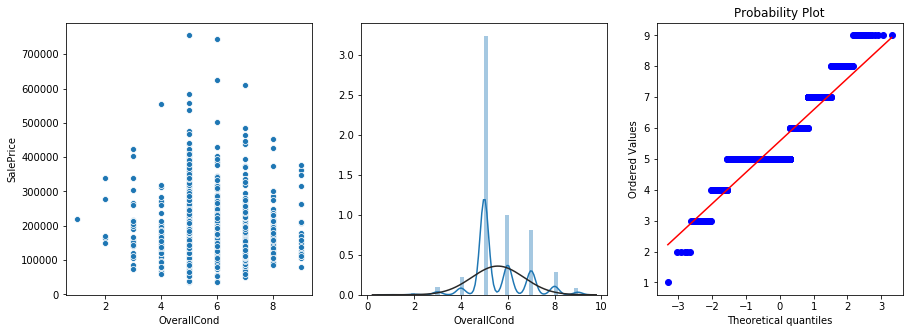

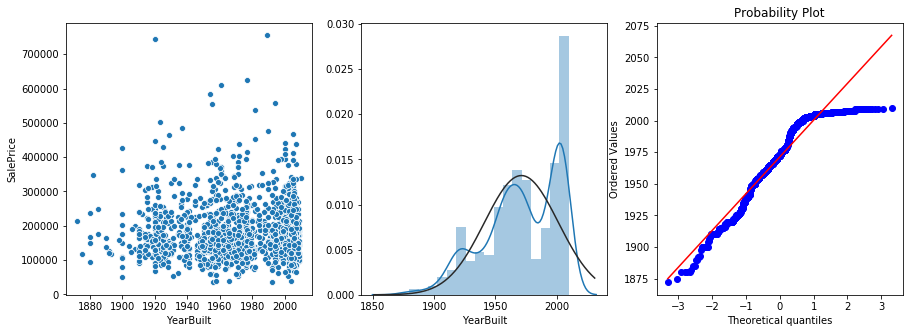

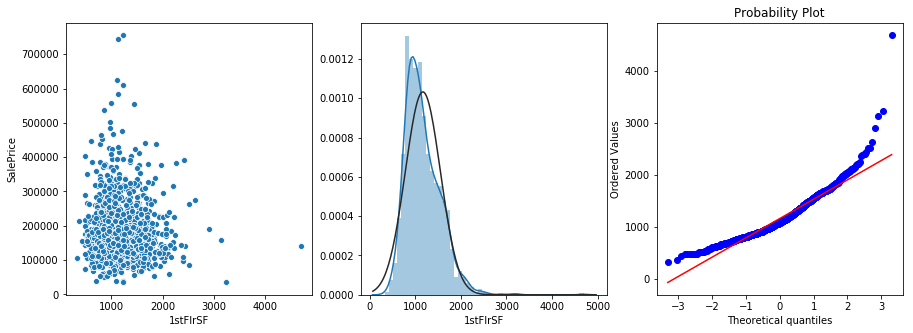

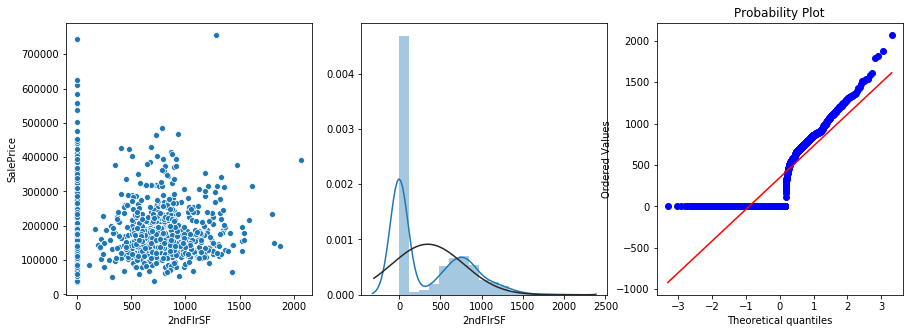

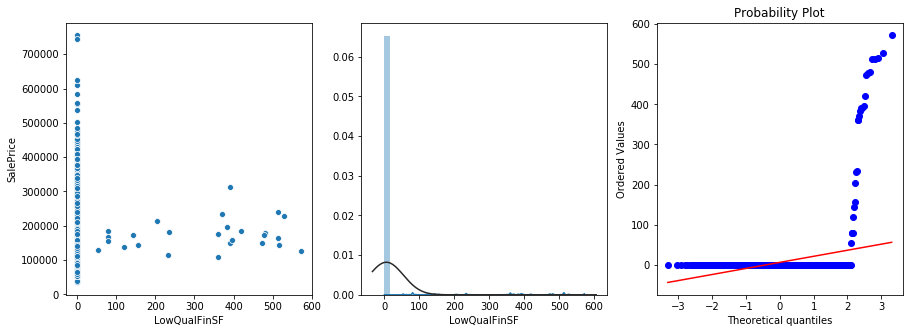

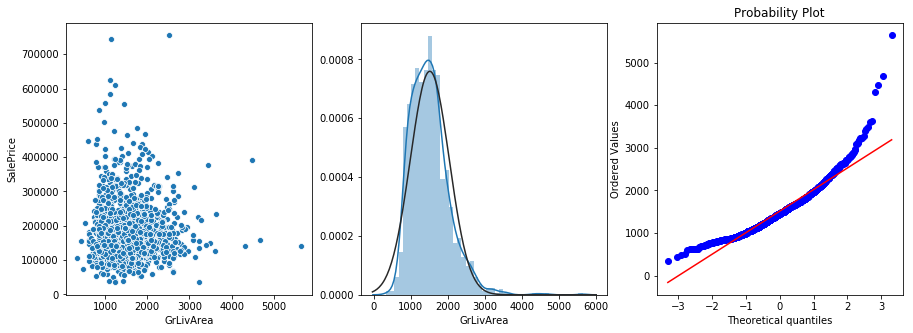

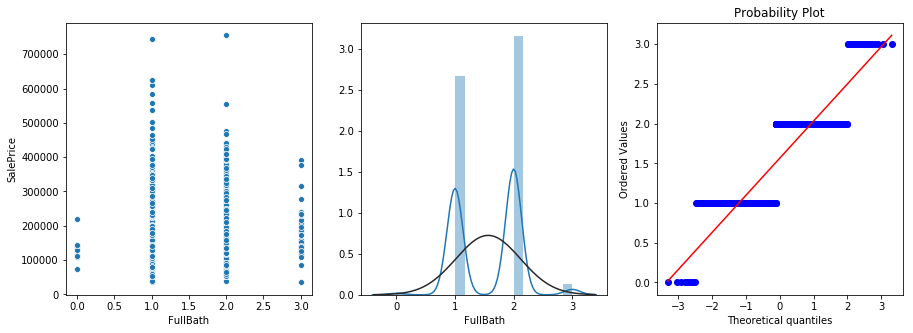

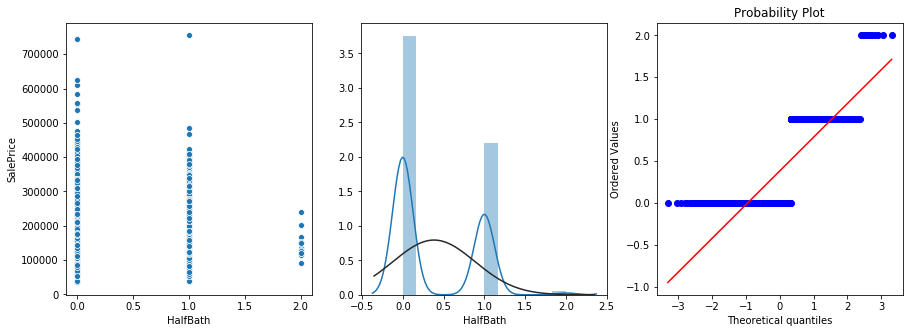

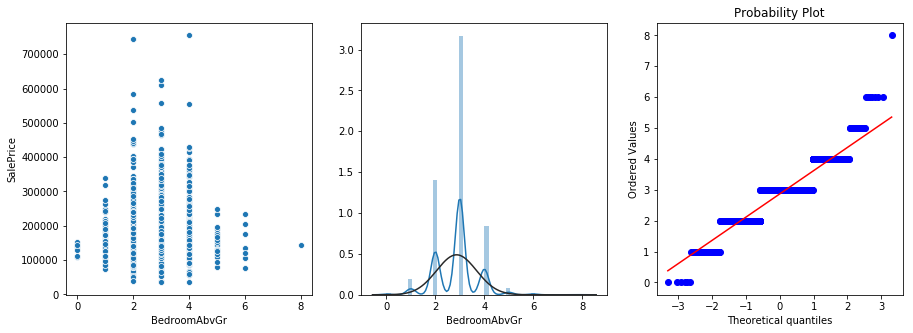

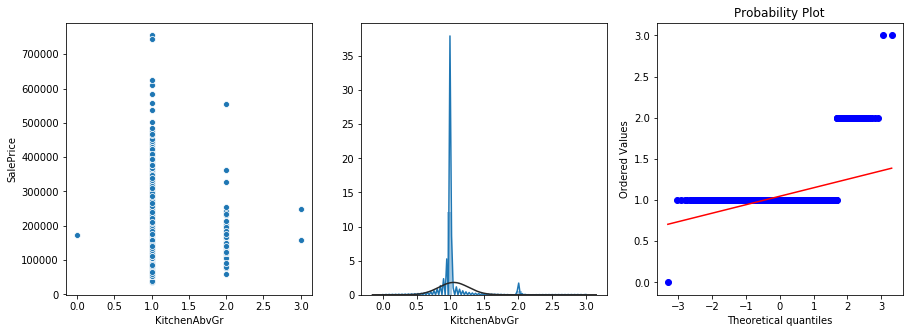

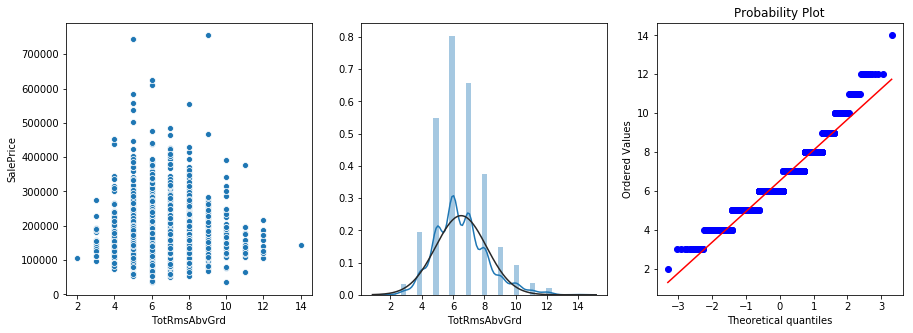

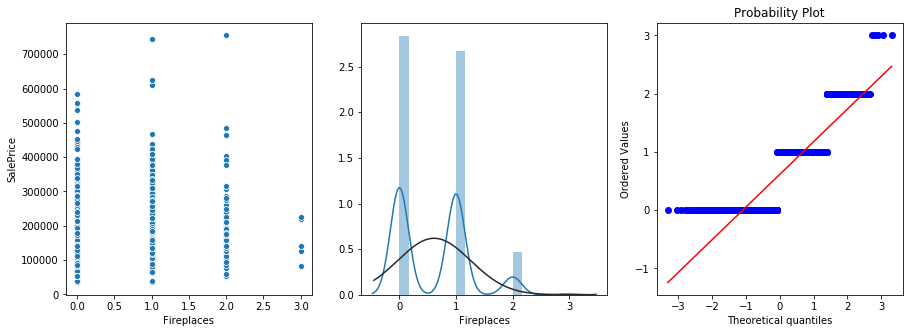

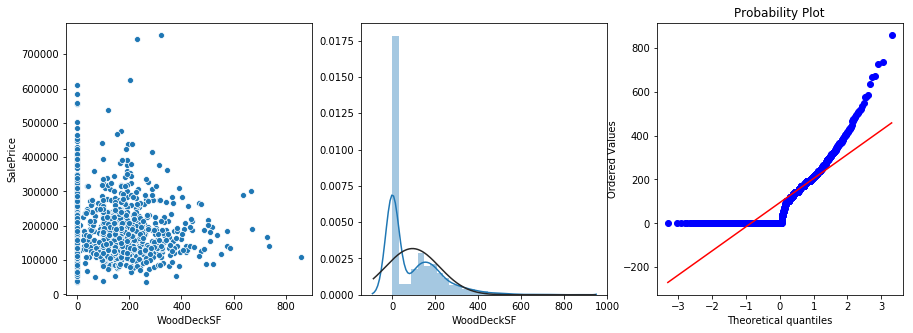

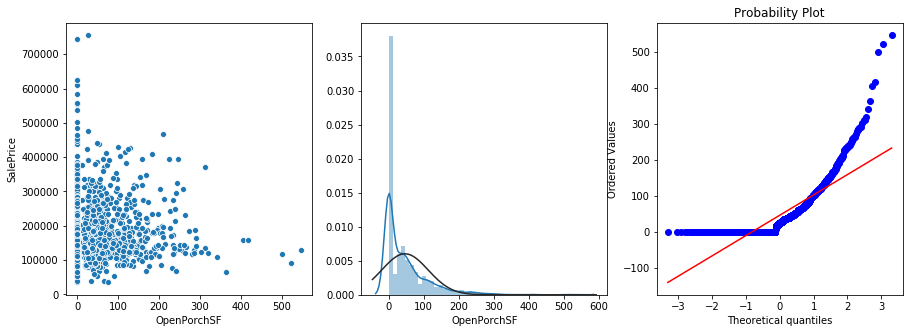

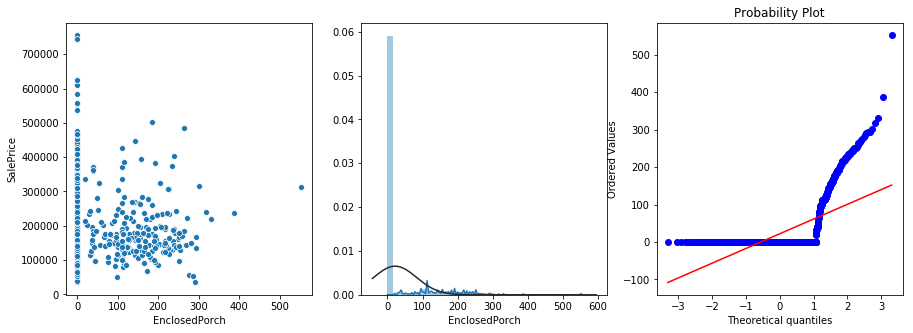

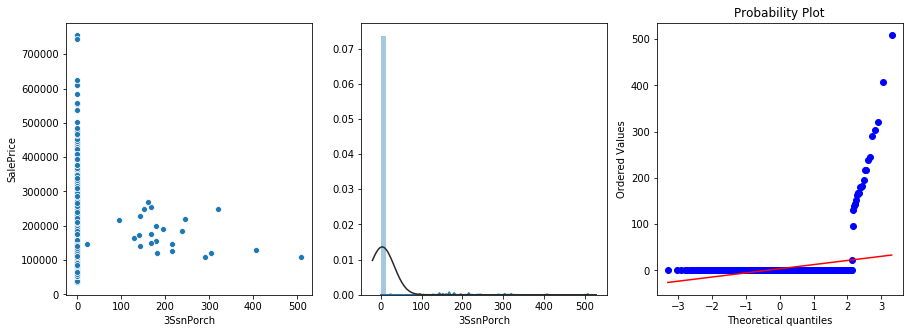

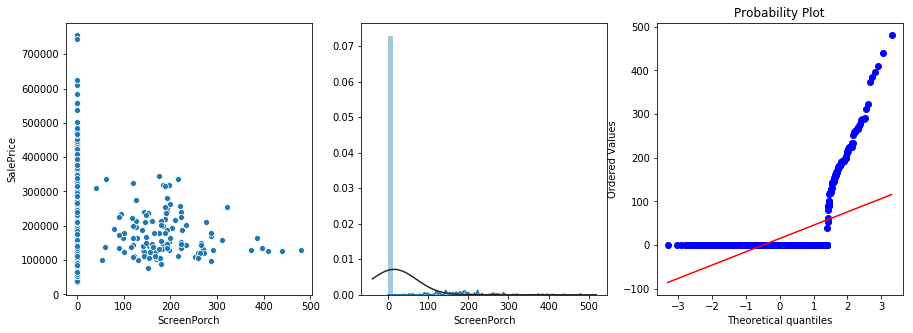

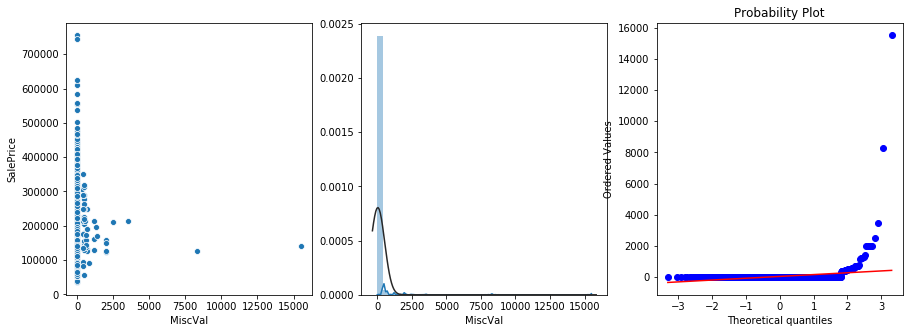

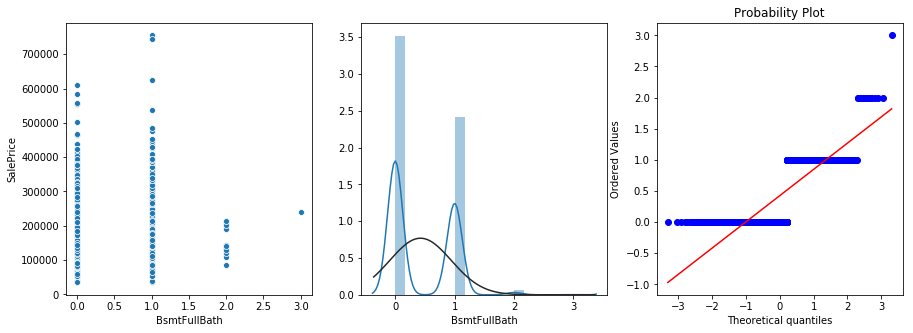

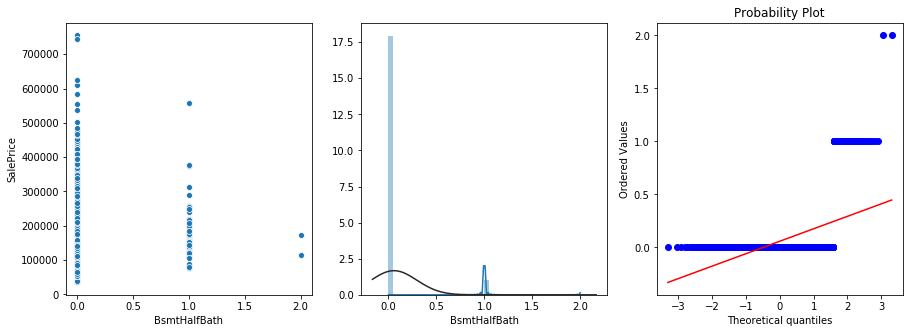

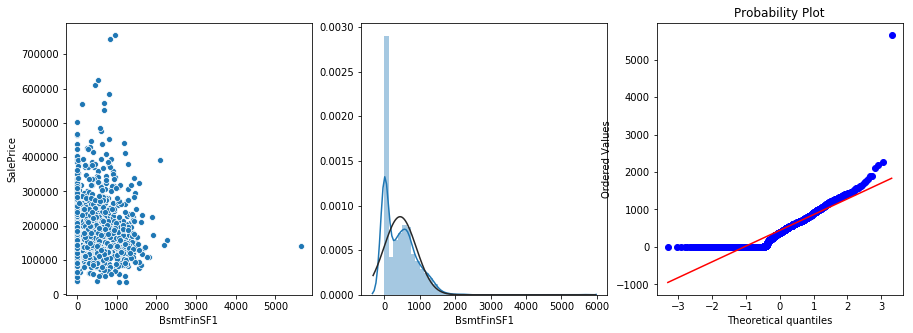

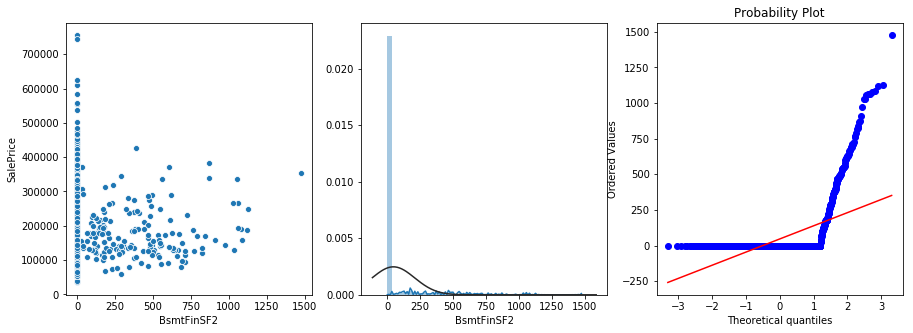

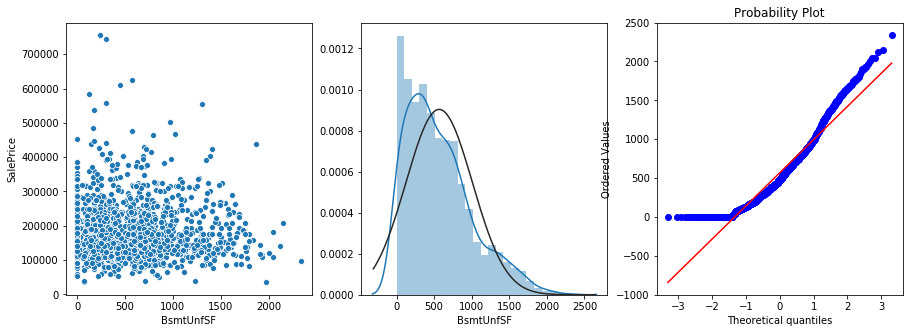

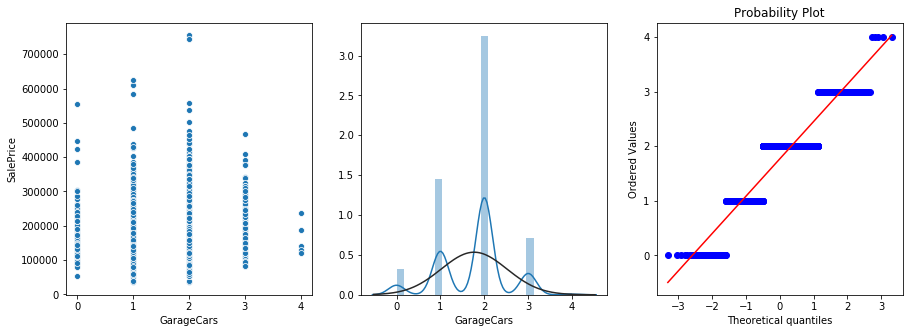

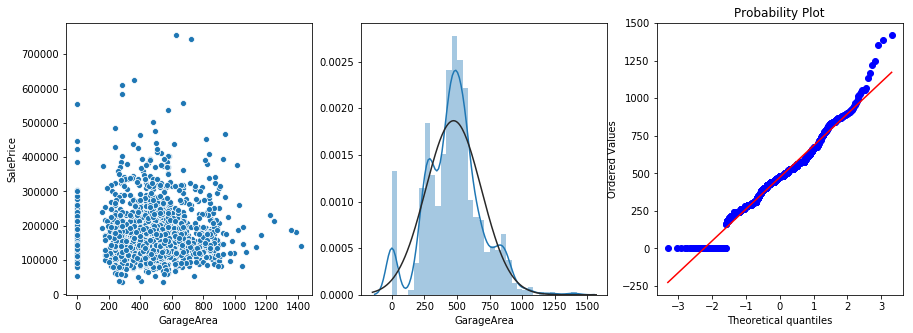

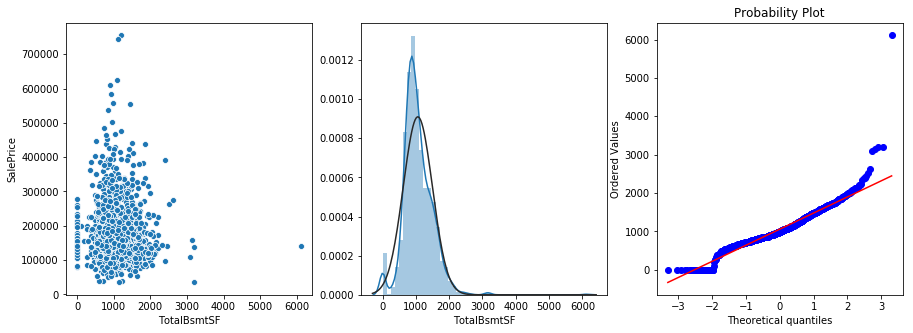

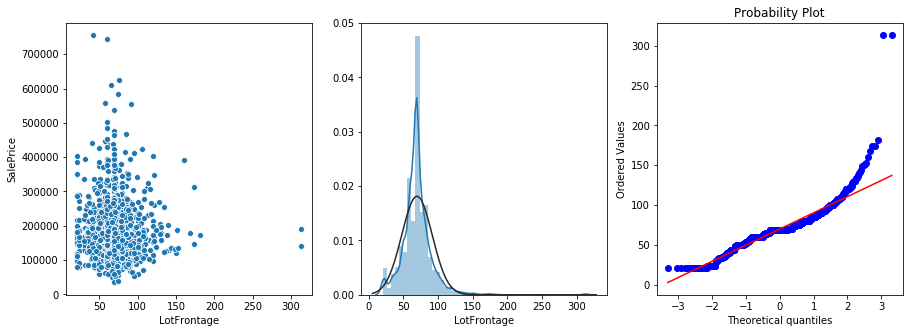

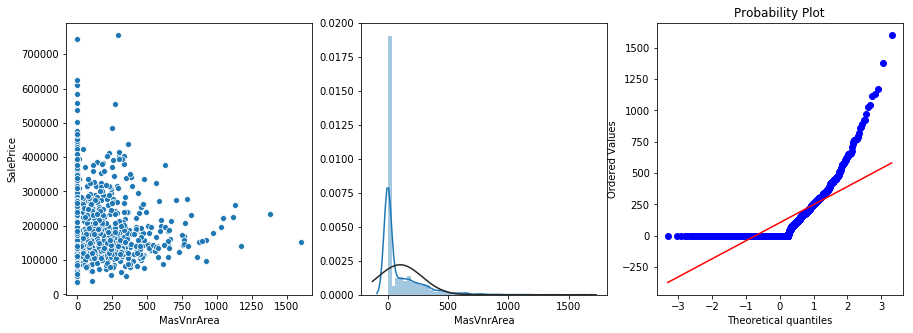

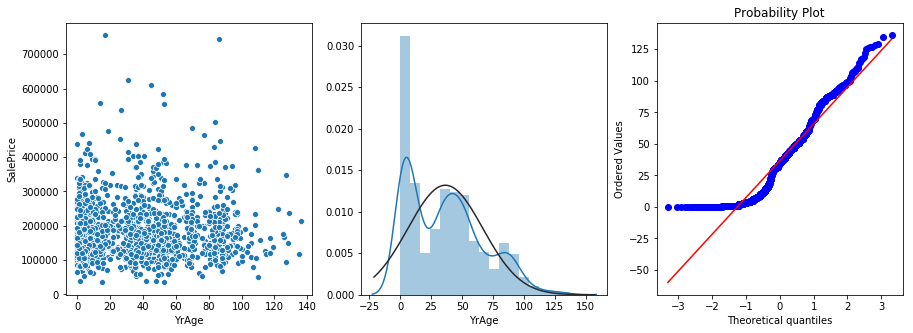

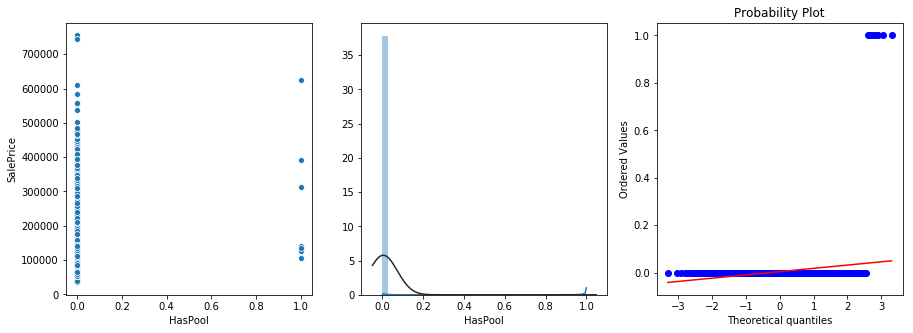

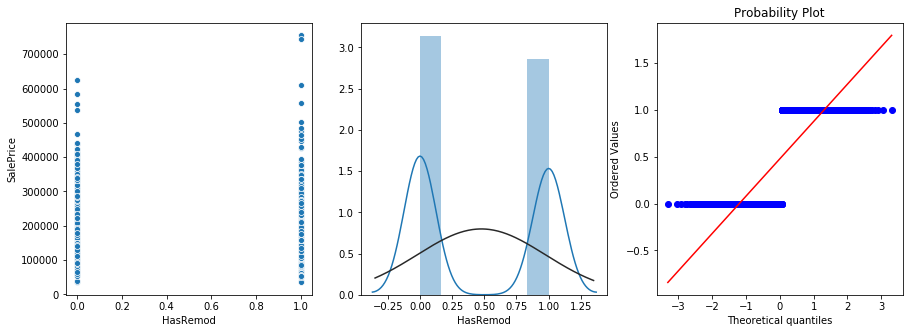

In [35]:
features = num_df.columns
figures_per_time = 3
count = 0
for feat in features:
    plt.figure(count,figsize=(15,5))
    plt.subplot(1,figures_per_time,1); sns.scatterplot(x=num_df[feat], y=y);
    plt.subplot(1,figures_per_time,2); sns.distplot(num_df[feat], fit=norm);
    plt.subplot(1,figures_per_time,3); stats.probplot(num_df[feat], plot=plt);
    count+=1

In [27]:
num_df.describe()

,LotArea,OverallQual,OverallCond,YearBuilt,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,...,BsmtFinSF2,BsmtUnfSF,GarageCars,GarageArea,TotalBsmtSF,LotFrontage,MasVnrArea,YrAge,HasPool,HasRemod
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,6.099315,5.575342,1971.267808,1162.626712,346.992466,5.844521,1515.463699,1.565068,0.382877,...,46.549315,567.240411,1.767123,472.980137,1057.429452,69.863699,103.117123,36.547945,0.004795,0.476712
std,9981.264932,1.382997,1.112799,30.202904,386.587738,436.528436,48.623081,525.480383,0.550916,0.502885,...,161.319273,441.866955,0.747315,213.804841,438.705324,22.027677,180.731373,30.250152,0.069100,0.499629
min,1300.000000,1.000000,1.000000,1872.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000
25%,7553.500000,5.000000,5.000000,1954.000000,882.000000,0.000000,0.000000,1129.500000,1.000000,0.000000,...,0.000000,223.000000,1.000000,334.500000,795.750000,60.000000,0.000000,8.000000,0.000000,0.000000
50%,9478.500000,6.000000,5.000000,1973.000000,1087.000000,0.000000,0.000000,1464.000000,2.000000,0.000000,...,0.000000,477.500000,2.000000,480.000000,991.500000,69.000000,0.000000,35.000000,0.000000,0.000000
75%,11601.500000,7.000000,6.000000,2000.000000,1391.250000,728.000000,0.000000,1776.750000,2.000000,1.000000,...,0.000000,808.000000,2.000000,576.000000,1298.250000,79.000000,164.250000,54.000000,0.000000,1.000000
max,215245.000000,10.000000,9.000000,2010.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,...,1474.000000,2336.000000,4.000000,1418.000000,6110.000000,313.000000,1600.000000,136.000000,1.000000,1.000000


In [28]:
from scipy.stats import skew 
skewness = num_df.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

MiscVal          24.451640
HasPool          14.337930
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.674865
LotFrontage       2.406671
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
1stFlrSF          1.375342
GrLivArea         1.365156
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
YrAge             0.608404
BsmtFullBath      0.595454
OverallQual       0.216721
BedroomAbvGr      0.211572
GarageArea        0.179796
HasRemod          0.093252
FullBath          0.036524
GarageCars       -0.342197
YearBuilt        -0.612831
dtype: float64

In [29]:
skewness = skewness[abs(skewness) > 0.5]
print("{} skewed numerical (>abs(0.5)) features to Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

skewed_features = skewness.index
for feat in skewed_features:
    num_df[feat] = boxcox1p(num_df[feat], boxcox_normmax(num_df[feat] + 10))
    
skewness = num_df.apply(lambda x: skew(x))

print("{} skewed numerical features after Box Cox transform".format(skewness.shape[0]))
print("Mean skewnees: {}".format(np.mean(skewness)))
skewness.sort_values(ascending=False)

27 skewed numerical (>abs(0.5)) features to Box Cox transform
Mean skewnees: 4.083848828164612


C:\Users\FadhelAdlansyah\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


33 skewed numerical features after Box Cox transform
Mean skewnees: 0.5794357558721545


HasPool          14.337930
3SsnPorch         7.637376
LowQualFinSF      7.301343
MiscVal           5.075658
BsmtHalfBath      3.855545
ScreenPorch       3.248931
BsmtFinSF2        2.520677
EnclosedPorch     2.186393
HalfBath          1.018176
2ndFlrSF          0.887030
MasVnrArea        0.791424
WoodDeckSF        0.683926
BsmtFullBath      0.553283
TotalBsmtSF       0.381261
BsmtFinSF1        0.334516
OpenPorchSF       0.275629
OverallQual       0.216721
BedroomAbvGr      0.211572
GarageArea        0.179796
Fireplaces        0.118892
HasRemod          0.093252
FullBath          0.036524
GrLivArea        -0.002019
1stFlrSF         -0.016295
BsmtUnfSF        -0.041259
YrAge            -0.071776
LotArea          -0.191006
YearBuilt        -0.246330
LotFrontage      -0.263354
GarageCars       -0.342197
OverallCond      -0.659316
TotRmsAbvGrd     -0.855859
KitchenAbvGr    -30.135066
dtype: float64

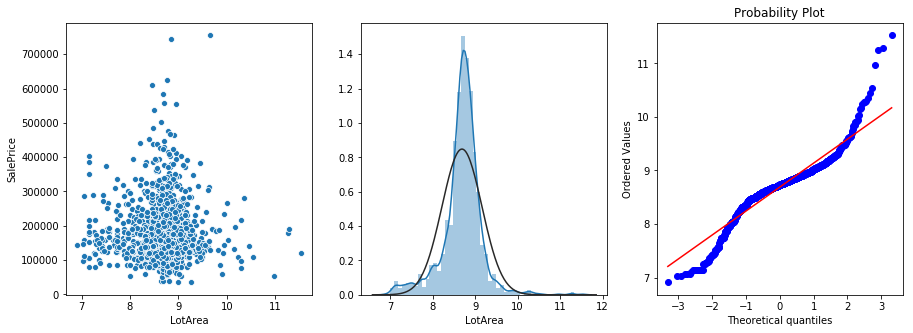

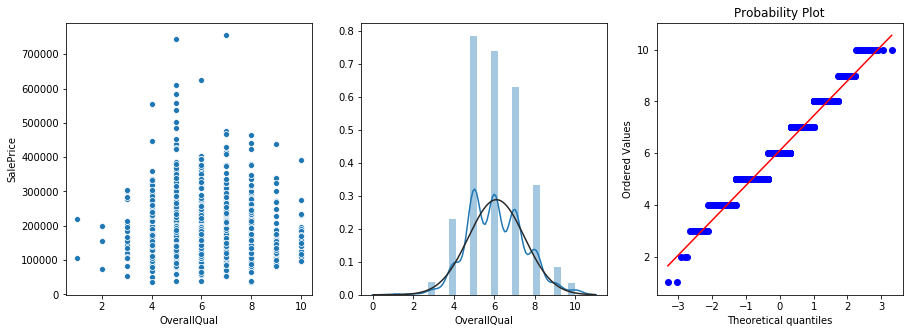

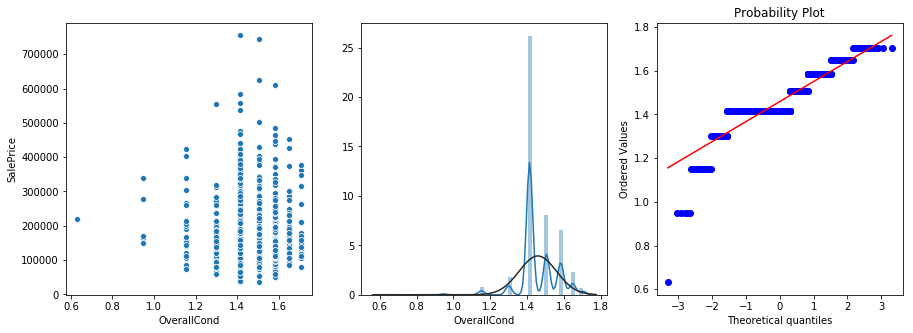

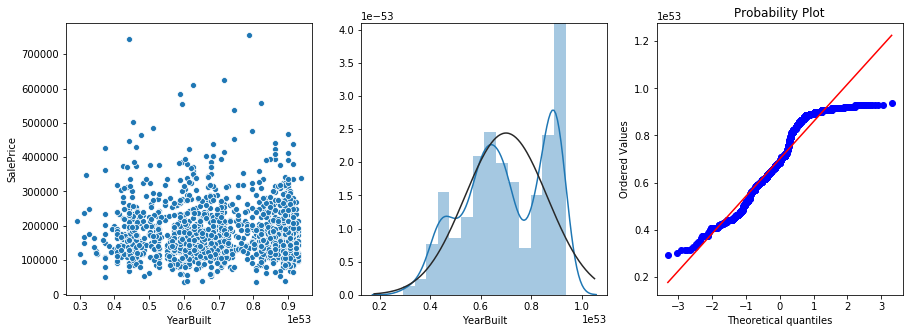

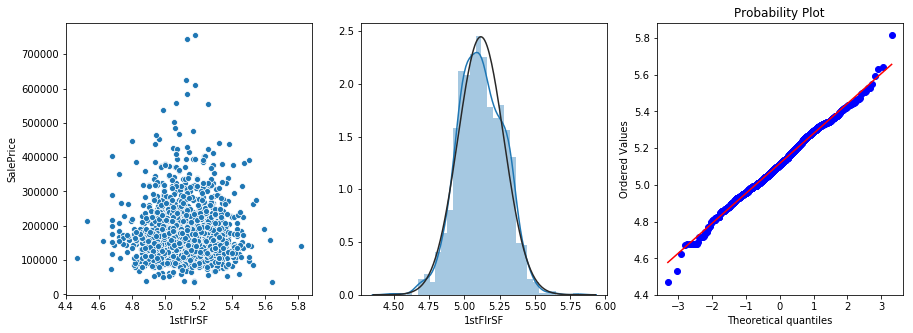

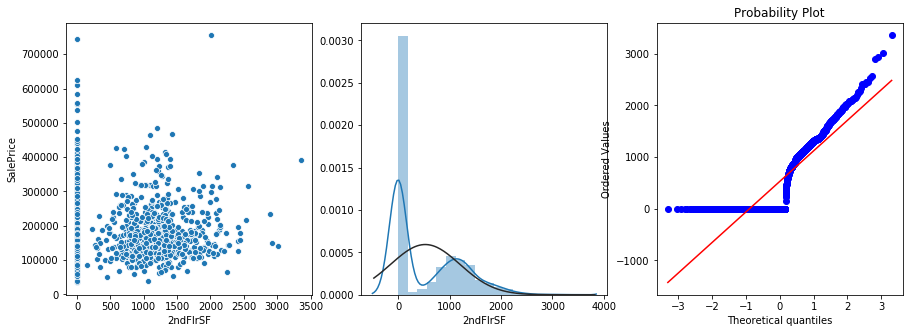

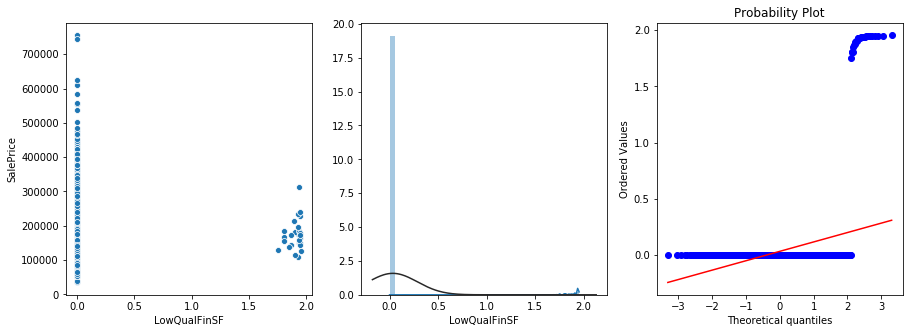

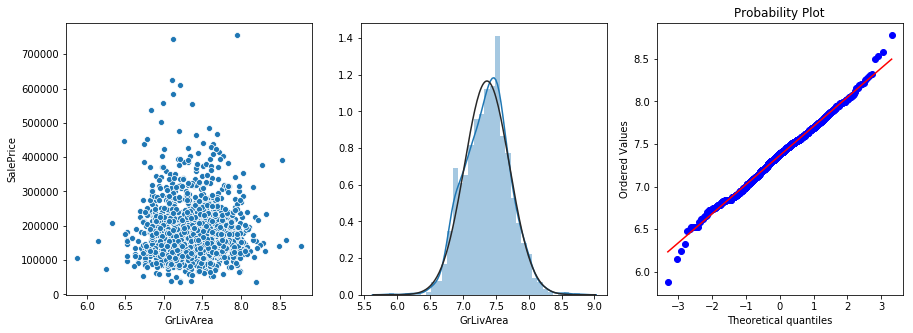

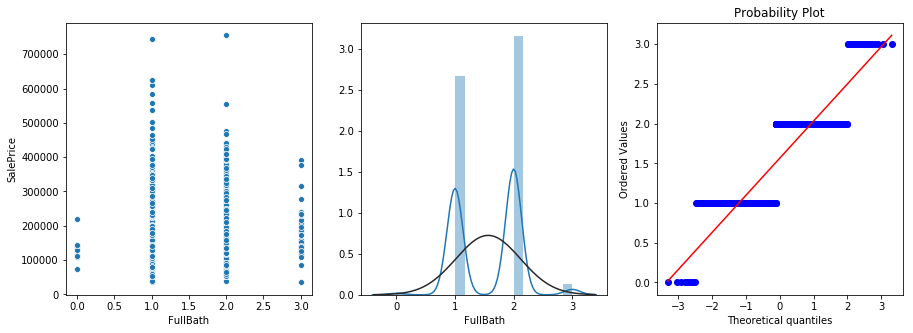

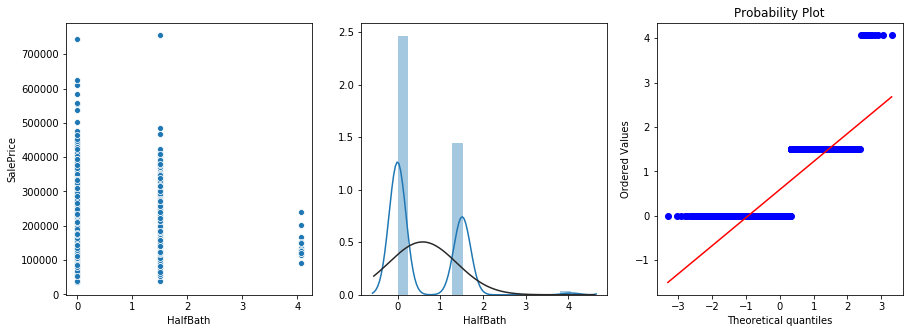

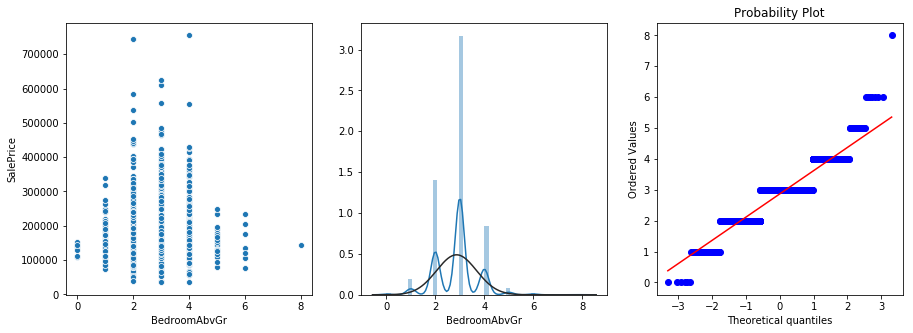

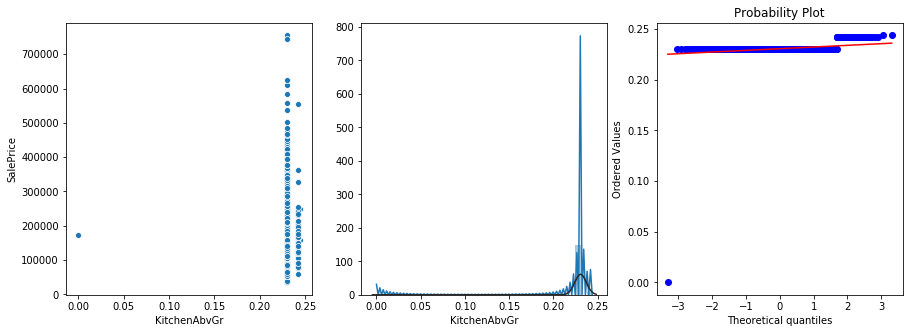

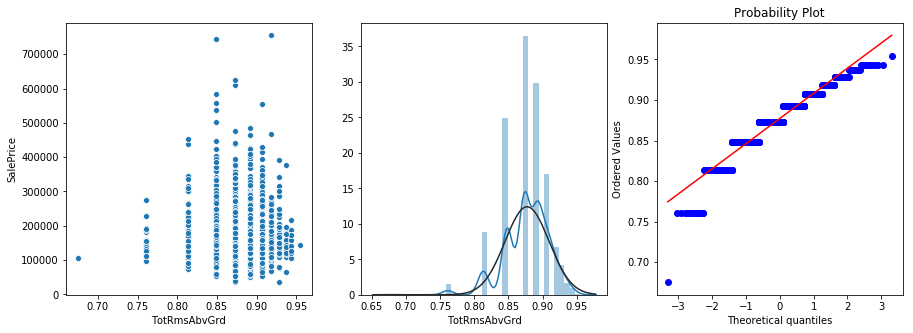

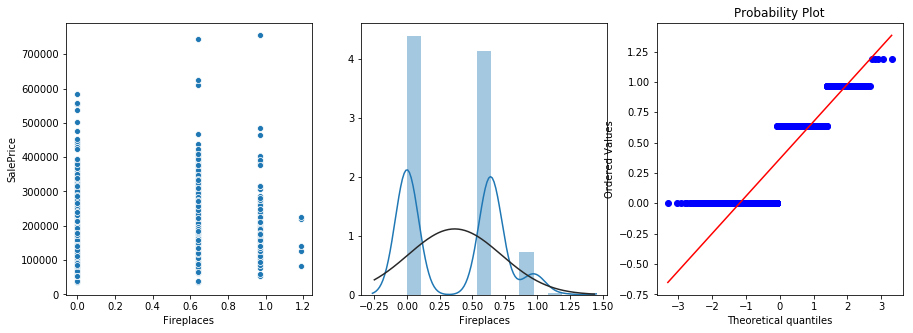

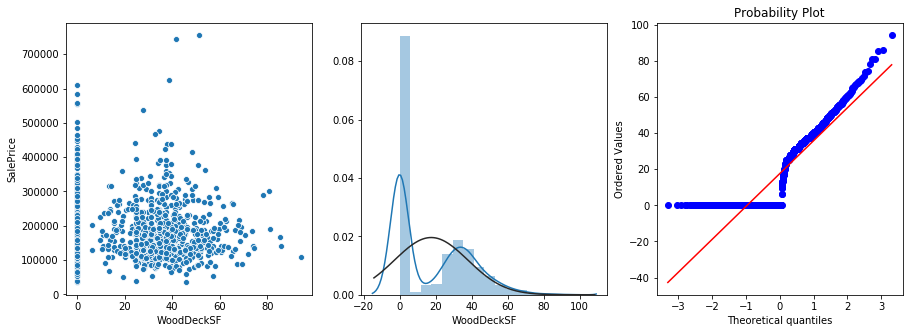

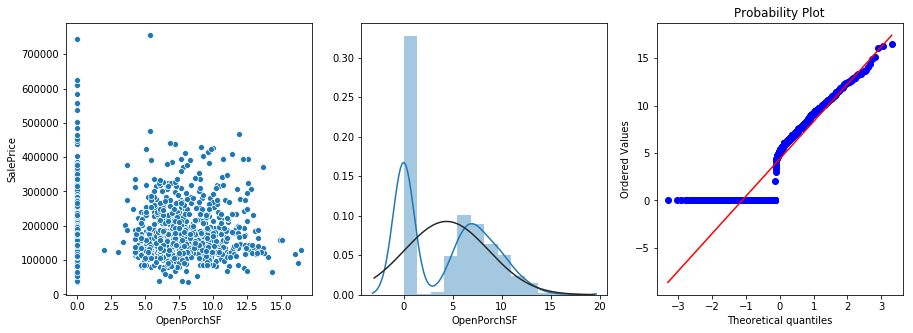

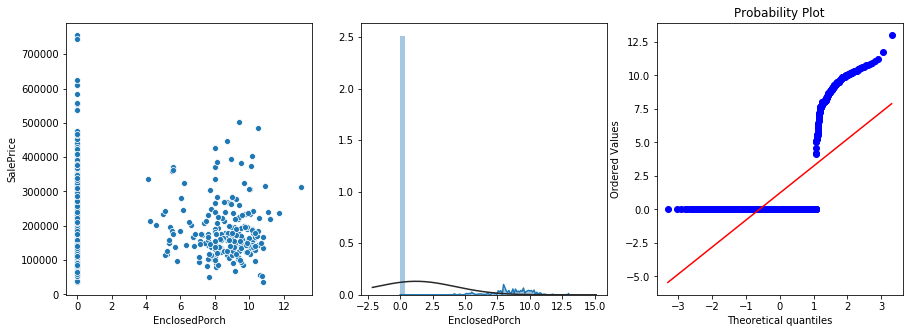

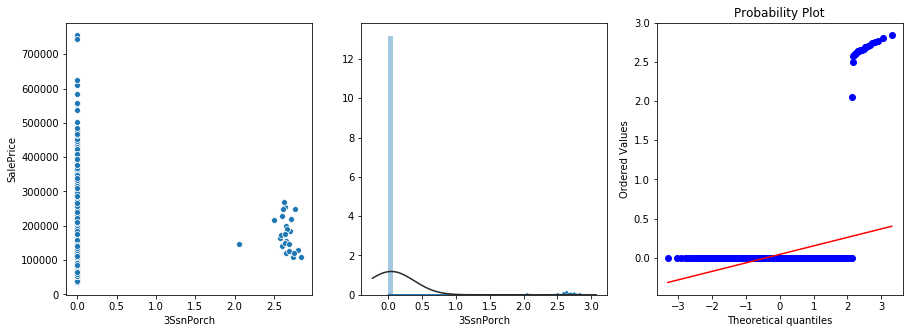

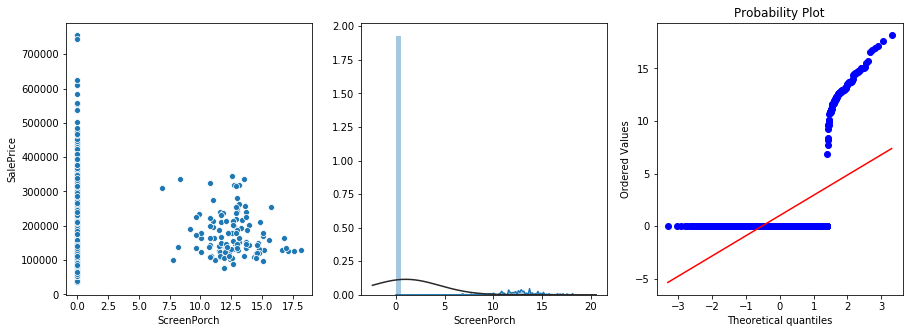

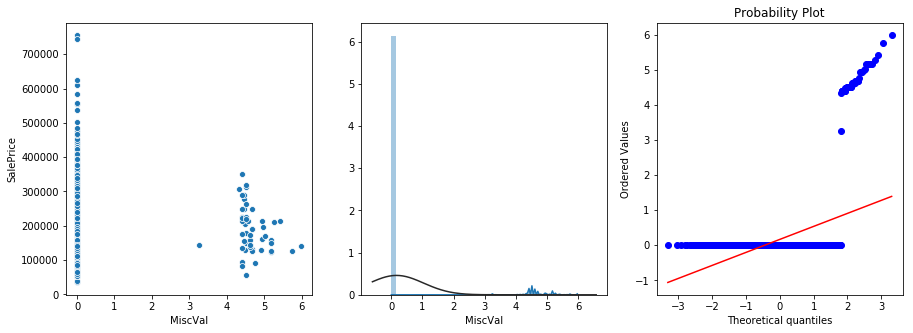

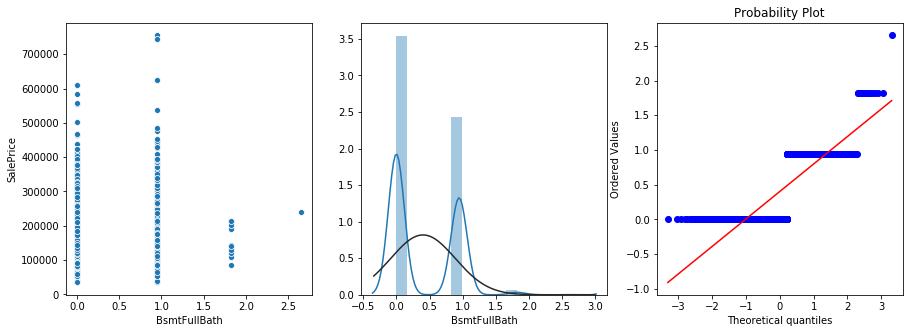

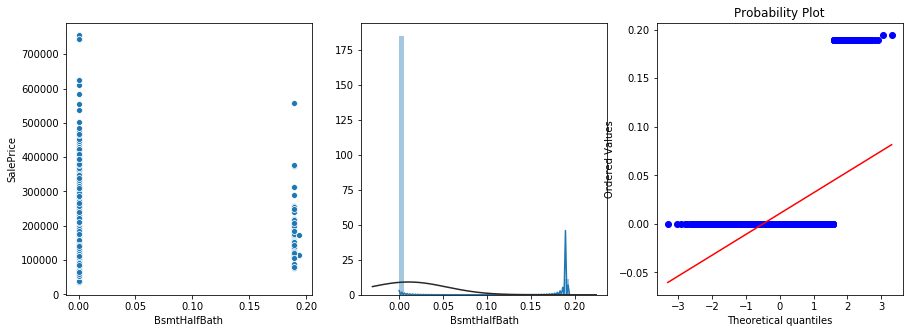

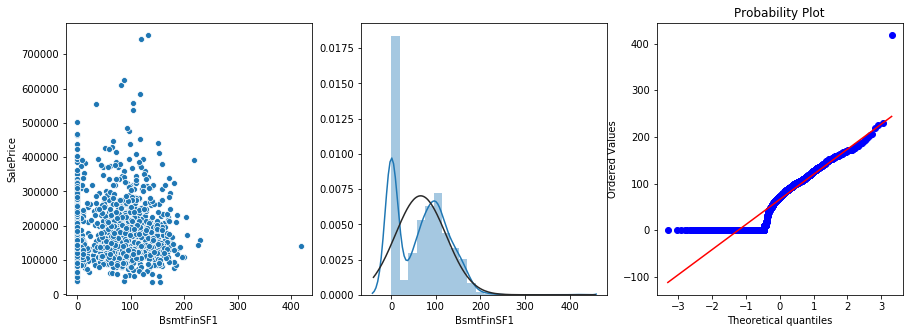

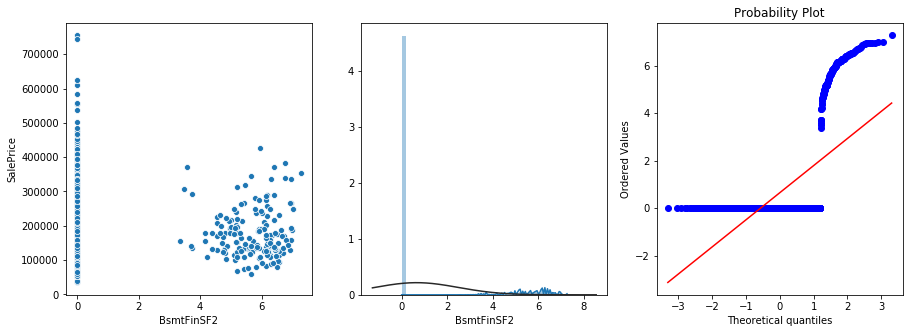

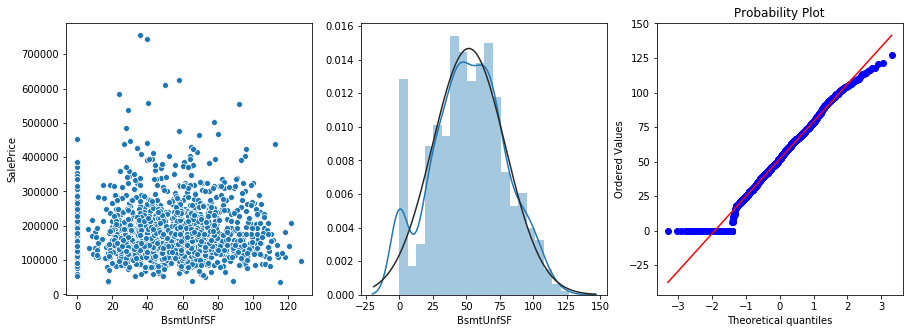

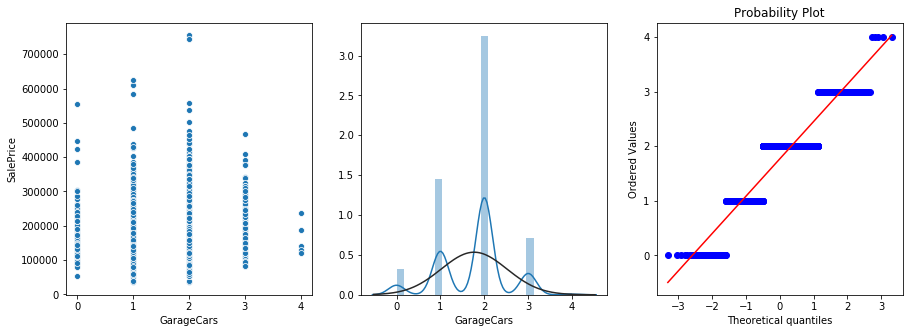

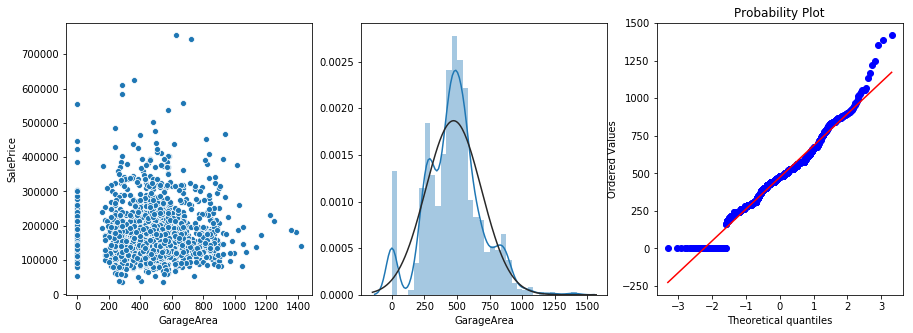

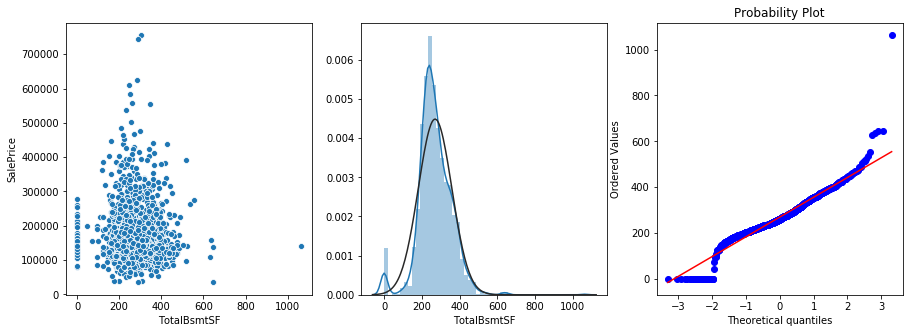

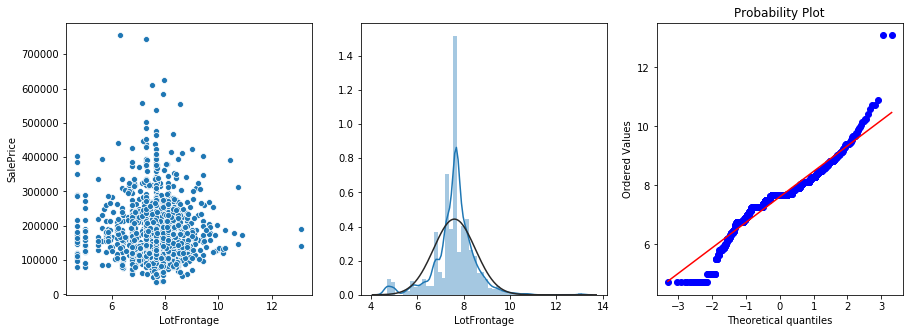

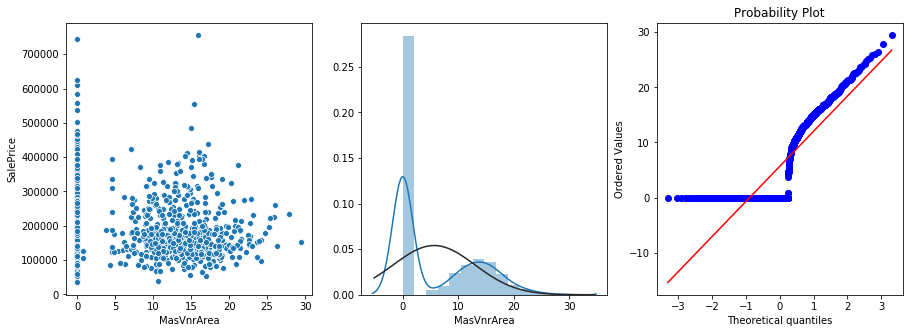

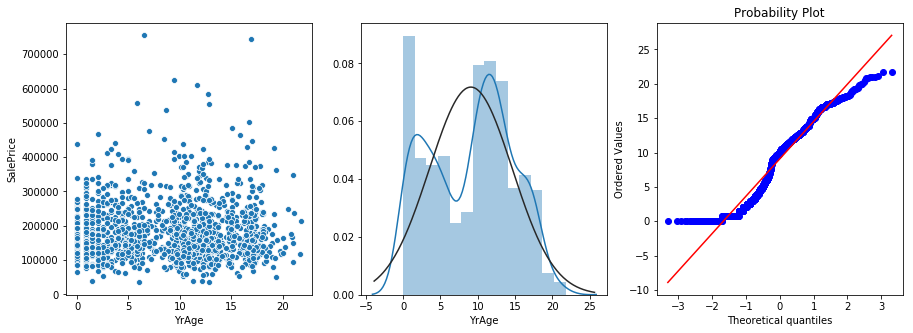

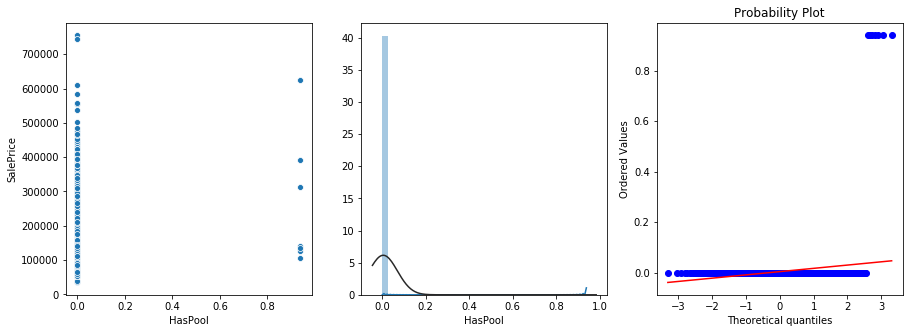

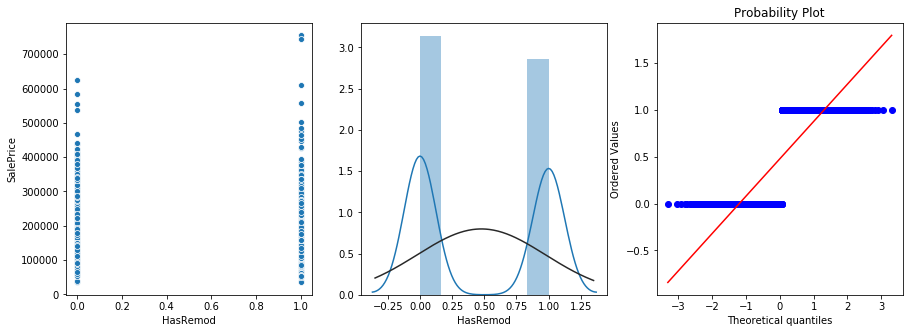

In [31]:
features = num_df.columns
figures_per_time = 3
count = 0
for feat in features:
    plt.figure(count,figsize=(15,5))
    plt.subplot(1,figures_per_time,1); sns.scatterplot(x=num_df[feat], y=y);
    plt.subplot(1,figures_per_time,2); sns.distplot(num_df[feat], fit=norm);
    plt.subplot(1,figures_per_time,3); stats.probplot(num_df[feat], plot=plt);
    count+=1

In [ ]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

In [ ]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df.select_dtypes(include=['object']).columns
print(categorical_features)
numerical_features = df.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
feat_num = df[numerical_features]
feat_cat = df[categorical_features]

In [ ]:
from scipy.stats import skew 
skewness = feat_num.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

In [ ]:
# plot and check the best lambda parameter for boxcox transformation

from scipy import stats
import matplotlib.pyplot as plt
np.random.seed(1234)

x = feat_num['PoolArea'] +1
y, lmax_mle = stats.boxcox(x)
lmax_pearsonr = stats.boxcox_normmax(x)

print(lmax_mle, lmax_pearsonr)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
sns.distplot(x)
ax2 = fig.add_subplot(122)
stats.boxcox_normplot(x, -10, 10, plot=ax2)
ax2.axvline(lmax_mle, color='r')
ax2.axvline(lmax_pearsonr, color='g', ls='--')
plt.show()

In [ ]:
feat_final = pd.concat([feat_num, feat_cat], axis=1)
feat_final = pd.get_dummies(feat_final)

In [ ]:
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error , make_scorer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# model scoring and validation function
def cv_rmse(model, X=feat_final):
    rmse = np.sqrt(-cross_val_score(model, X, y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

# rmsle scoring function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4, #was 3
                                       learning_rate=0.01, 
                                       n_estimators=9000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2, # 'was 0.2'
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

# xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
#                                      max_depth=3, min_child_weight=0,
#                                      gamma=0, subsample=0.7,
#                                      colsample_bytree=0.7,
#                                      objective='reg:linear', nthread=-1,
#                                      scale_pos_weight=1, seed=27,
#                                      reg_alpha=0.00006)



# setup models hyperparameters using a pipline
# The purpose of the pipeline is to assemble several steps that can be cross-validated together, while setting different parameters.
# This is a range of values that the model considers each time in runs a CV
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]




# Kernel Ridge Regression : made robust to outliers
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))

# LASSO Regression : made robust to outliers
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                    alphas=alphas2,random_state=42, cv=kfolds))

# Elastic Net Regression : made robust to outliers
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, 
                         alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))


stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, lightgbm),
                                meta_regressor=elasticnet,
                                use_features_in_secondary=True)

# store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'lightgbm': lightgbm}
#           'xgboost': xgboost}
predictions = {}
scores = {}

In [ ]:
for name, model in models.items():
    
    model.fit(feat_final, y)
    predictions[name] = np.expm1(model.predict(feat_final))
    
    score = cv_rmse(model)
    scores[name] = (score.mean(), score.std())

In [ ]:
scores